In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [2]:
base_folder = "data"

In [3]:
scale_features = True

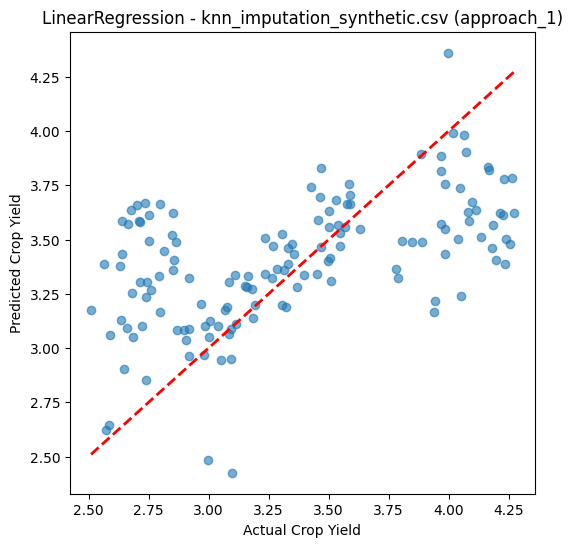

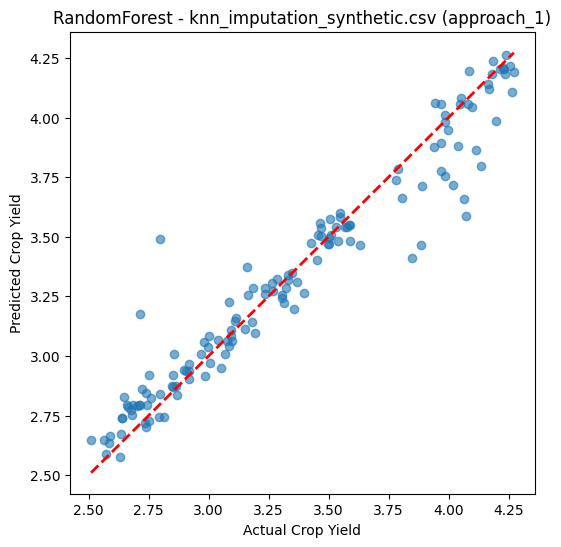

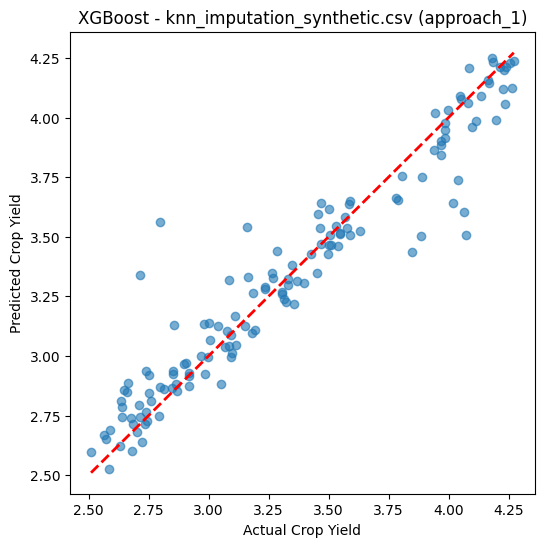

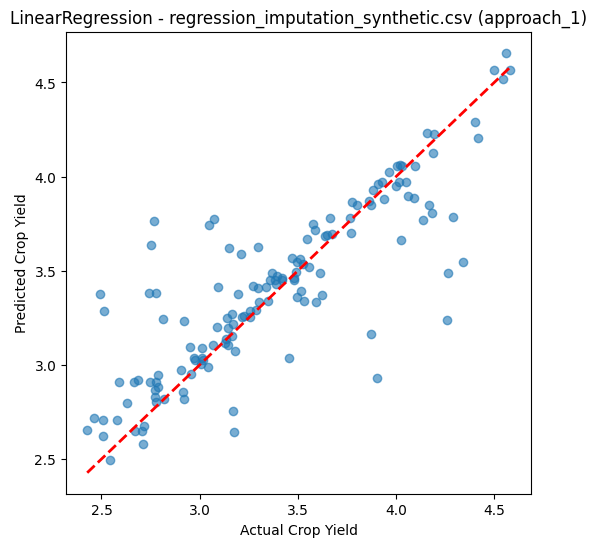

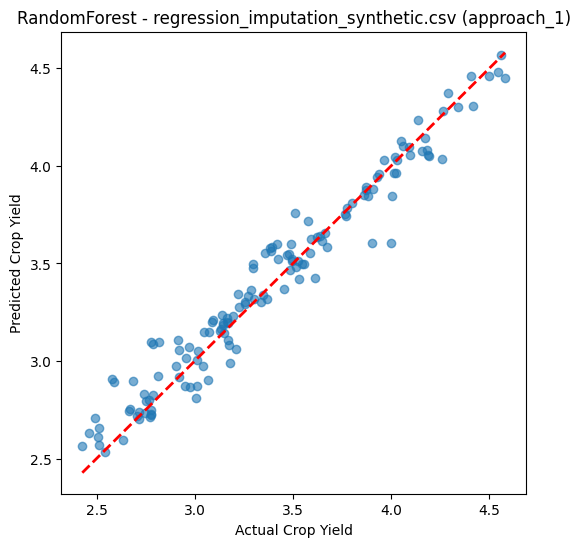

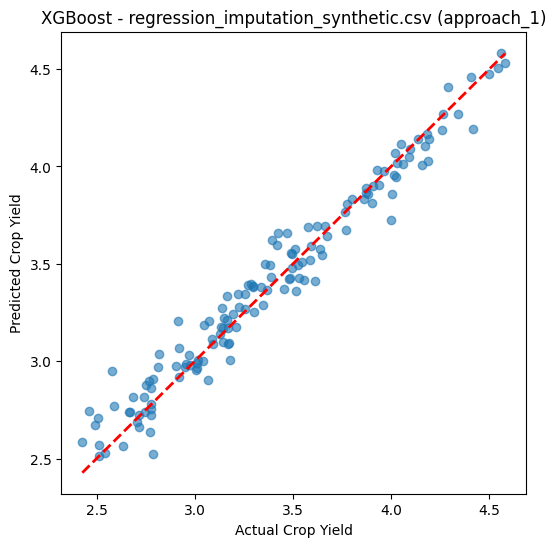

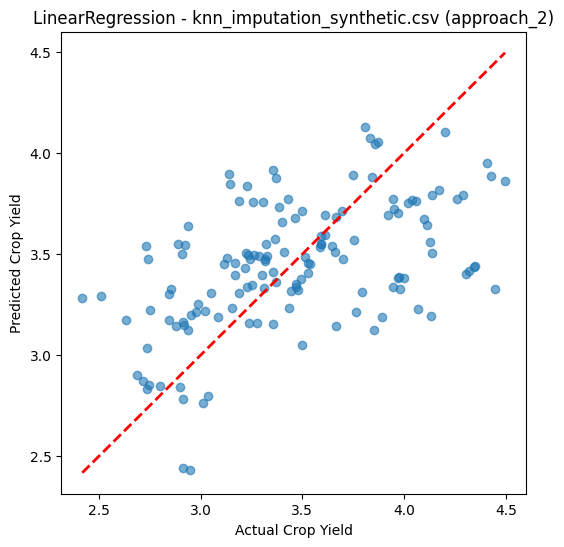

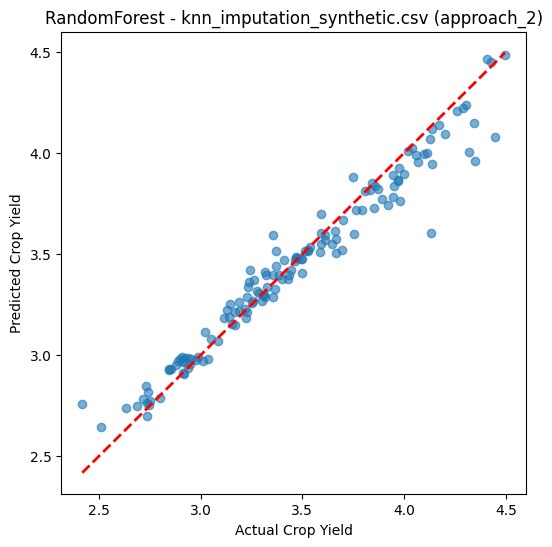

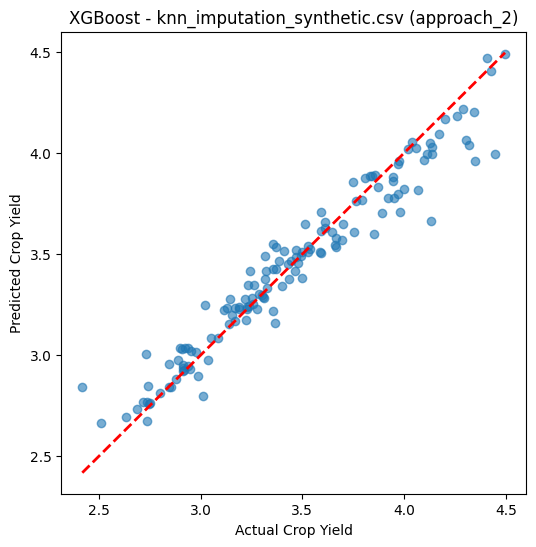

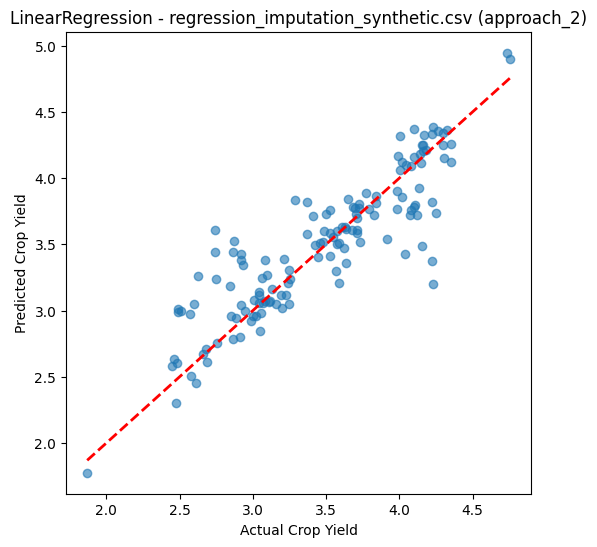

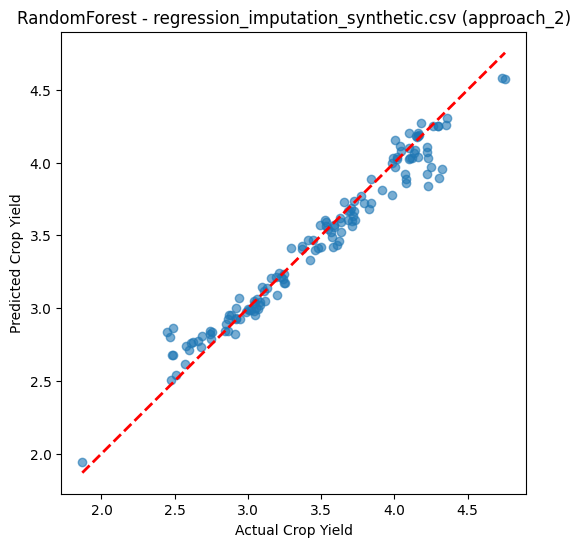

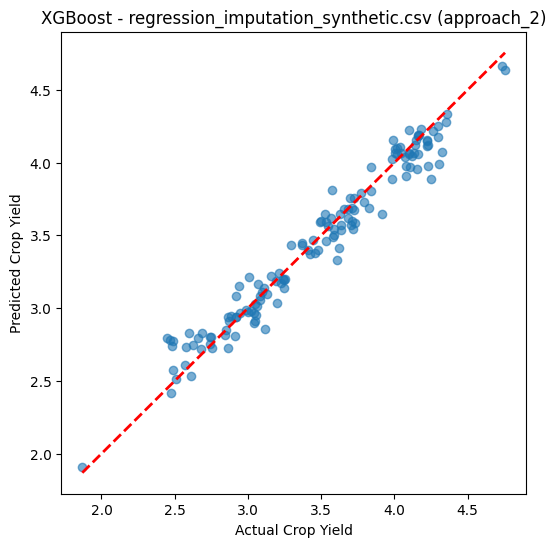

Saved model results summary CSV


,Dataset,Approach,Model,MAE,RMSE,R2,Adj_R2
0,knn_imputation_synthetic.csv,approach_1,LinearRegression,0.348574,0.447602,0.282752,0.214980
1,knn_imputation_synthetic.csv,approach_1,RandomForest,0.087639,0.136595,0.933203,0.926892
2,knn_imputation_synthetic.csv,approach_1,XGBoost,0.100728,0.154789,0.914224,0.906119
3,regression_imputation_synthetic.csv,approach_1,LinearRegression,0.180493,0.294912,0.704731,0.676832
4,regression_imputation_synthetic.csv,approach_1,RandomForest,0.086865,0.117656,0.953004,0.948563
5,regression_imputation_synthetic.csv,approach_1,XGBoost,0.081288,0.108081,0.960342,0.956595
6,knn_imputation_synthetic.csv,approach_2,LinearRegression,0.335121,0.418590,0.250070,0.093562
7,knn_imputation_synthetic.csv,approach_2,RandomForest,0.072582,0.108088,0.949997,0.939561
8,knn_imputation_synthetic.csv,approach_2,XGBoost,0.086365,0.124139,0.934043,0.920278
9,regression_imputation_synthetic.csv,approach_2,LinearRegression,0.191616,0.276783,0.776866,0.730299


In [4]:
results_list = []

for approach in os.listdir(base_folder):
    approach_path = os.path.join(base_folder, approach)
    if not os.path.isdir(approach_path):
        continue
    
    for file_name in os.listdir(approach_path):
        if file_name.endswith("_synthetic.csv"):
            file_path = os.path.join(approach_path, file_name)
            df = pd.read_csv(file_path)
            
            X = df.drop(columns=['Crop_Yield_t_per_ha'])
            y = df['Crop_Yield_t_per_ha']
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            
            # scaling the features for linear Regression
            if scale_features:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_train_scaled = X_train.values
                X_test_scaled = X_test.values

            # Linear Regression
            lr = LinearRegression()
            lr.fit(X_train_scaled, y_train)
            y_pred_lr = lr.predict(X_test_scaled)
            
            # Random Forest
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_test)

            # XGBoost
            xgb_model = xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=4,
                random_state=42
            )
            xgb_model.fit(X_train, y_train)
            y_pred_xgb = xgb_model.predict(X_test)

            models = {
                "LinearRegression": y_pred_lr,
                "RandomForest": y_pred_rf,
                "XGBoost": y_pred_xgb
            }

            n = len(y_test)  
            p = X.shape[1]   

            for model_name, y_pred in models.items():
                r2 = r2_score(y_test, y_pred)
                adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

                results_list.append({
                    "Dataset": file_name,
                    "Approach": approach,
                    "Model": model_name,
                    'MAE': mean_absolute_error(y_test, y_pred),
                    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
                    "R2": r2,
                    "Adj_R2": adj_r2
                })

                plt.figure(figsize=(6, 6))
                plt.scatter(y_test, y_pred, alpha=0.6)
                plt.plot([y_test.min(), y_test.max()], 
                         [y_test.min(), y_test.max()], 
                         'r--', lw=2)  # reference line
                plt.xlabel("Actual Crop Yield")
                plt.ylabel("Predicted Crop Yield")
                plt.title(f"{model_name} - {file_name} ({approach})")

                plt.show()


results_df = pd.DataFrame(results_list)
results_df.reset_index(drop=True, inplace=True)

results_df.to_csv(os.path.join(base_folder, "model_results_summary.csv"), index=False)
print("Saved model results summary CSV")
results_df
